In [3]:
# import the necessary libraries

# For data augmentation while data preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pretrained MobileNet model.
from tensorflow.keras.applications import MobileNetV2

# Performing MaxPooling operations
from tensorflow.keras.layers import MaxPooling2D

# For performing dropout operation
from tensorflow.keras.layers import Dropout

# For flattening operation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# Input() is used to instantiate a Keras tensor.
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# We use adam optimizer
from tensorflow.keras.optimizers import Adam

# Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Converts a PIL Image instance to a Numpy array.
from tensorflow.keras.preprocessing.image import img_to_array

# Loads an image into PIL format.
from tensorflow.keras.preprocessing.image import load_img

# Converts a class vector (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

# Binarize labels in a one-vs-all fashion.
from sklearn.preprocessing import LabelBinarizer

# Performing train-test split
from sklearn.model_selection import train_test_split

# For printing the metrics
from sklearn.metrics import classification_report

# For using strings in file structure path format
from imutils import paths

# For plotting losse functions
import matplotlib.pyplot as plt

# For performing mathematical computations
import numpy as np

# For file-related operations
import os

Total training images 1150
Total training images (Damaged) 920
Total training images (Damaged) 230

Total validation images 460
Total training images (Damaged) 230
Total training images (Damaged) 230

Total Number of Images:  1610


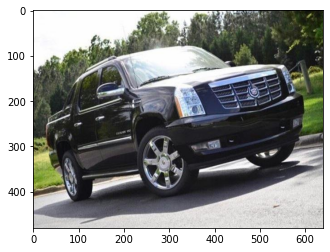

In [4]:
# Path to directory containing data
DataDir = "D:/Car-Damage-Classification-main/data1a"

# Path to training directory
train_dir = os.path.join(DataDir, 'training/')

# Path to validation directory
val_dir = os.path.join(DataDir, 'validation/')

# Path for damaged training images
train_damage = os.path.join(train_dir, '00-damage')
# Path for training images not damaged
train_not_damage = os.path.join(val_dir, '01-whole')

# Number of damaged training images
num_train_damage = len(os.listdir(train_damage))

# Number of training images not damaged
num_train_not_damage = len(os.listdir(train_not_damage))

# Path for damaged validation
val_damage = os.path.join(val_dir, '00-damage')

# Path for validation images not damaged
val_not_damage = os.path.join(val_dir, '01-whole')

# Number of damaged validation images
num_val_damage = len(os.listdir(val_damage))

# Number of validation images not damaged
num_val_not_damage = len(os.listdir((val_not_damage)))

# Number of training images
num_train = num_train_damage + num_train_not_damage

# Number of validation images
num_val = num_val_damage + num_val_not_damage


# Total images
total_images = num_val + num_train
print("Total training images",num_train)
print("Total training images (Damaged)", num_train_damage)
print("Total training images (Damaged)", num_train_not_damage)
print()

print("Total validation images", num_val)
print("Total training images (Damaged)", num_val_damage)
print("Total training images (Damaged)", num_val_not_damage)
print()

print("Total Number of Images: ",total_images)

# Plotting a sample image
plt.grid('')
image = plt.imread('D:/Car-Damage-Classification-main/data1a/training/01-whole/0195.jpg')
plt.imshow(image)
plt.show()

In [5]:
# initializing the hyperparameters
initial_lr = 0.001
epochs = 100
batch_size = 64

# Classes which are detected
classes = ["00-damage", "01-whole"]

In [6]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

# It stores the data or feature set
data = []

# It stores the corrosponding labels
labels = []

for class_ in classes:
    path = os.path.join(train_dir, class_)
    for image in os.listdir(path):
    	image_path = os.path.join(path, image)
    	image_ = load_img(image_path, target_size=(224, 224))
    	image_ = img_to_array(image_)
    	image_ = preprocess_input(image_)

    	data.append(image_)
    	labels.append(class_)


for class_ in classes:
    path = os.path.join(val_dir, class_)
    for image in os.listdir(path):
    	image_path = os.path.join(path, image)
    	image_ = load_img(image_path, target_size=(224, 224))
    	image_ = img_to_array(image_)
    	image_ = preprocess_input(image_)

    	data.append(image_)
    	labels.append(class_)
        
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)



(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

[INFO] loading images...


In [7]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [8]:
# loading the MobileNetV2 network, ensuring the topmost fully-connected
# layer sets are left off
model_base = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 2s 0us/step


In [9]:
# Constructing the top architecture of our model, which is placed over the 
# pretrained model
model_head = model_base.output
# MaxPooling layer

model_head = MaxPooling2D(pool_size=(5, 5))(model_head)
# Flatten layer
model_head = Flatten(name="flatten")(model_head)

# Activation function relu
model_head = Dense(128, activation="relu")(model_head)

# Performing dropout
model_head = Dropout(0.5)(model_head)

# Final output layer consists of softmax layer
model_head = Dense(2, activation="softmax")(model_head)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_final = Model(inputs=model_base.input, outputs=model_head)

In [10]:
# looping over all the layers and setting each individual layer trainability
# to false.
for layer in model_base.layers:
	layer.trainable = False

In [11]:
# Setting optimizer to Adam 
optim = Adam(lr=initial_lr, decay=initial_lr / epochs)

# Compiling our model
model_final.compile(loss="binary_crossentropy", optimizer=optim,
	metrics=["accuracy"])

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# train the head of the network
model_train = model_final.fit(
#     Generates image generator from ImageGeneratorClass for inputing images in batches
	aug.flow(trainX, trainY, batch_size=batch_size),
#     Number of steps to be taken in one epoch over image batches
	steps_per_epoch=len(trainX) // batch_size,
#     Validation data
	validation_data=(testX, testY),
    
#     Steps for validation data
	validation_steps=len(testX) // batch_size,
    
#     Number of epochs
	epochs=50)

Epoch 1/50
28/28 [==============================] - 115s 4s/step - loss: 0.5527 - accuracy: 0.7399 - val_loss: 0.4627 - val_accuracy: 0.7870
Epoch 2/50
28/28 [==============================] - 113s 4s/step - loss: 0.4457 - accuracy: 0.8114 - val_loss: 0.3916 - val_accuracy: 0.8370
Epoch 3/50
28/28 [==============================] - 113s 4s/step - loss: 0.3946 - accuracy: 0.8350 - val_loss: 0.3239 - val_accuracy: 0.8717
Epoch 4/50
28/28 [==============================] - 115s 4s/step - loss: 0.3362 - accuracy: 0.8683 - val_loss: 0.3156 - val_accuracy: 0.8609
Epoch 5/50
28/28 [==============================] - 112s 4s/step - loss: 0.3422 - accuracy: 0.8547 - val_loss: 0.3318 - val_accuracy: 0.8630
Epoch 6/50
28/28 [==============================] - 113s 4s/step - loss: 0.3404 - accuracy: 0.8519 - val_loss: 0.3292 - val_accuracy: 0.8500
Epoch 7/50
28/28 [==============================] - 112s 4s/step - loss: 0.2959 - accuracy: 0.8823 - val_loss: 0.3141 - val_accuracy: 0.8674
Epoch 8/50
28

In [14]:
# Now, we predict on test set.
predict = model_final.predict(testX, batch_size=batch_size)

# for each image in the test set we find the index of the
# label with corresponding largest predicted probability
predict_index = np.argmax(predict, axis=1)

# Displaying classification report
print(classification_report(testY.argmax(axis=1), predict_index,
	target_names=lb.classes_))

# Storing our model for further use.
model_final.save("Car_detection.model", save_format="h5")

              precision    recall  f1-score   support

   00-damage       0.95      0.73      0.83       230
    01-whole       0.78      0.97      0.87       230

    accuracy                           0.85       460
   macro avg       0.87      0.85      0.85       460
weighted avg       0.87      0.85      0.85       460



C:\Users\user\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [15]:
model_final.save('stage1.h5')

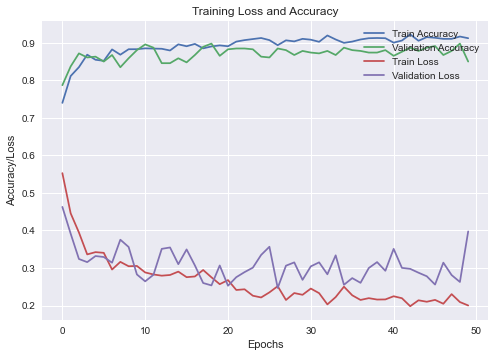

In [25]:
# plotting training loss and accuracy
num = epochs

# matplotlib style
plt.style.use("seaborn")
plt.figure()

# Plotting all the required quantities
# Train Accuracy
plt.plot(np.arange(0, num), model_train.history["accuracy"], label="Train Accuracy")

# Validation Accuracy
plt.plot(np.arange(0, num), model_train.history["val_accuracy"], label="Validation Accuracy")

# Train Loss
plt.plot(np.arange(0, num), model_train.history["loss"], label="Train Loss")

# Validation Loss
plt.plot(np.arange(0, num), model_train.history["val_loss"], label="Validation Loss")

# Setting the title
plt.title("Training Loss and Accuracy")

# Setting the label
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="upper right")

# Saving the Model
plt.savefig("Car_Detection.png")

In [2]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import os
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
from tensorflow.random import set_seed
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
pd.options.display.max_colwidth = 100
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(42)
warnings.filterwarnings('ignore')
IMG_SIZE = 150
SEED = 42

In [35]:
main_path = "D:/Car-Damage-Classification-main/data2a"
train_path = os.path.join(main_path,"training")
train_front = glob.glob(train_path+"/00-front/*.jpeg")
train_rear = glob.glob(train_path+"/01-rear/*.jpeg")
train_side = glob.glob(train_path+"/02-side/*.jpeg")

In [36]:
#Train list:
train_list = [x for x in train_front]
train_list.extend([x for x in train_rear])
train_list.extend([x for x in train_side])
df_train = pd.DataFrame(np.concatenate([
                       ['0']*len(train_front),
                       ['1']*len(train_rear),
                       ['2']*len(train_side)]),
                  columns = ['label'])
df_train['image'] = [x for x in train_list]

In [37]:
df_train

,label,image
0,0,D:/Car-Damage-Classification-main/data2a\training/00-front\0001.jpeg
1,0,D:/Car-Damage-Classification-main/data2a\training/00-front\0002.JPEG
2,0,D:/Car-Damage-Classification-main/data2a\training/00-front\0003.JPEG
3,0,D:/Car-Damage-Classification-main/data2a\training/00-front\0004.JPEG
4,0,D:/Car-Damage-Classification-main/data2a\training/00-front\0005.JPEG
...,...,...
980,2,D:/Car-Damage-Classification-main/data2a\training/02-side\0268.JPEG
981,2,D:/Car-Damage-Classification-main/data2a\training/02-side\0269.JPEG
982,2,D:/Car-Damage-Classification-main/data2a\training/02-side\0270.JPEG
983,2,D:/Car-Damage-Classification-main/data2a\training/02-side\0271.jpeg


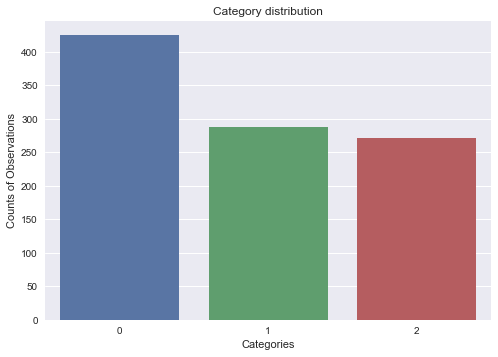

In [38]:
sns.countplot(df_train['label'])
plt.title('Category distribution')
plt.xlabel('Categories')
plt.ylabel('Counts of Observations');

In [39]:
path = 'D:/Car-Damage-Classification-main/data2a/training'
#List of image:
img_list = list(df_train['image'])
data_img = []
for each in img_list:
               #Each image path:
               each_path = os.path.join(path, each)
               #Read each image:
               each_img = cv2.imread(each_path)
               #OpenCv default color is BGR. Convert it to RGB:
               each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
               #Resize the images:
               each_img_resized = cv2.resize(each_img, (128,128))
               #Save arrays to a list:
               data_img.append(each_img_resized)
# Converting list to numpy array
X = np.array(data_img)

In [40]:
print('Shape of X: ', X.shape)

Shape of X:  (985, 128, 128, 3)


In [41]:
y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df_train['label'].values.reshape(-1,1))

In [42]:
print('Shape of y: ', y.shape)

Shape of y:  (985, 3)


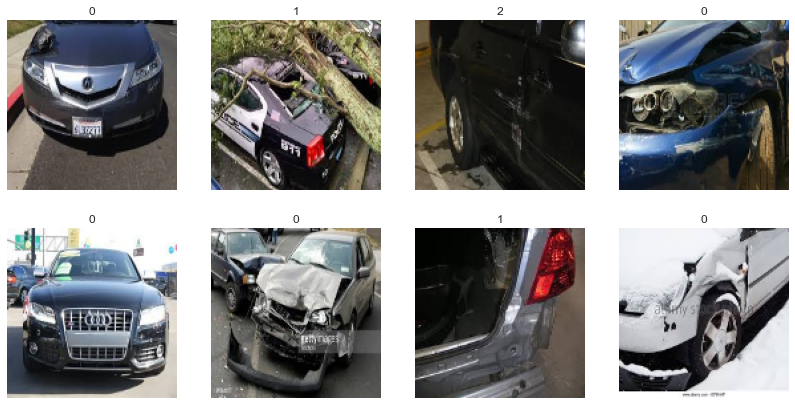

In [43]:
indices = np.random.randint(0,985,8)
i = 1
plt.figure(figsize=(14,7))
for each in indices:
    plt.subplot(2,4,i)
    plt.imshow(X[each])
    plt.title(df_train['label'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

In [44]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (669, 128, 128, 3)
y_train shape:  (669, 3)
X_val shape  :  (168, 128, 128, 3)
y_val shape  :  (168, 3)
X_test shape :  (148, 128, 128, 3)
y_test shape :  (148, 3)


In [45]:
train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
train_gen.fit(X_train)
validation_gen.fit(X_val)

In [46]:
#Note that you can decrease batch size and increase number of epochs if you want to maximise your model accuracy:
batch_size = 64
epochs = 10

In [47]:
base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)

83697664/83683744 [==============================] - 17s 0us/step


In [48]:
#We use 6, because we have 6 categories:
head = Dense(3, activation='softmax')(x)
model = Model(inputs=base.input, outputs=head)

In [49]:
model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

In [72]:
history = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = 5,
               validation_data = validation_gen.flow(X_val, y_val)
)

Epoch 1/5
11/11 [==============================] - 211s 17s/step - loss: 0.2376 - accuracy: 0.9193 - val_loss: 0.7977 - val_accuracy: 0.7024
Epoch 2/5
11/11 [==============================] - 186s 17s/step - loss: 0.2422 - accuracy: 0.9088 - val_loss: 0.7329 - val_accuracy: 0.7262
Epoch 3/5
11/11 [==============================] - 166s 15s/step - loss: 0.2381 - accuracy: 0.9058 - val_loss: 0.9045 - val_accuracy: 0.6905
Epoch 4/5
11/11 [==============================] - 173s 16s/step - loss: 0.2119 - accuracy: 0.9223 - val_loss: 0.8994 - val_accuracy: 0.7083
Epoch 5/5
11/11 [==============================] - 168s 15s/step - loss: 0.2114 - accuracy: 0.9193 - val_loss: 1.1420 - val_accuracy: 0.6607


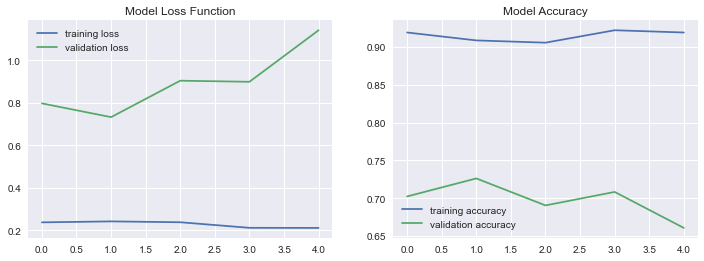

In [73]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend();

In [75]:
model.save('stage2new.h5')

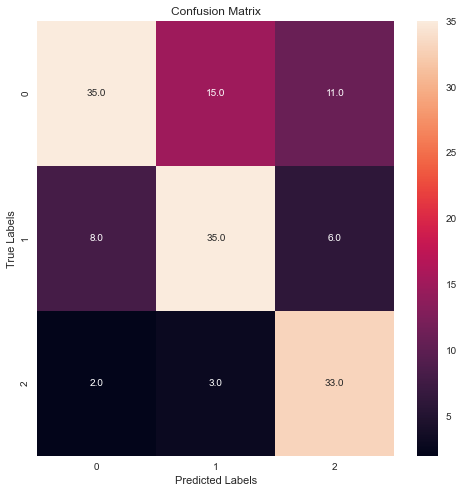

In [74]:
# Predicting labels from X_test data
y_pred = model.predict(X_test)
# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)
# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [56]:
my_model = keras.models.load_model("stage1.h5")

In [57]:
image_path = 'D:/Car-Damage-Classification-main/data2a/training/00-front/0018.jpeg'

In [58]:
image_ = load_img(image_path, target_size=(224, 224))
image_ = img_to_array(image_)
image_ = preprocess_input(image_)

In [59]:
data = []

In [60]:
data.append(image_)

In [61]:
data = np.array(data, dtype="float32")

In [62]:
my_model.predict(data)

array([[0.99824595, 0.00175402]], dtype=float32)

In [65]:
my_model.predict(data)[0][0]

0.99824595

In [76]:
my_model2 = keras.models.load_model("stage2new.h5")

In [82]:
data_img = []
each_img = cv2.imread("D:/Car-Damage-Classification-main/data2a/validation/01-rear/0018.jpeg")
#OpenCv default color is BGR. Convert it to RGB:
each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
#Resize the images:
each_img_resized = cv2.resize(each_img, (128,128))
#Save arrays to a list:
data_img.append(each_img_resized)
# Converting list to numpy array
X = np.array(data_img)
my_model2.predict(X)[0][1]

0.9389177

In [4]:
parts_model = keras.models.load_model("D:/Car-Genesis-main/Car-Genesis-main/Trained Model/vehicle_weights.h5")

In [48]:
X = []
x = cv2.imread("D:/Car-Damage-Classification-main/data2a/training/02-side/0084.jpeg", cv2.IMREAD_COLOR)
x = cv2.resize(x, (224,224))
x = np.array(x)
x = x/255
X.append(x)
X = np.array(X)
predict = parts_model.predict(X)

In [49]:
predict

array([[0.0315365 , 0.03566429, 0.08310774, 0.01631578, 0.09004716,
        0.17469853, 0.5475227 , 0.02110728]], dtype=float32)

In [50]:
class_dict = {0:'unknown',
 1:'head lamp',
 2:'door scratch',
 3:'glass shatter',
 4:'tail lamp',
 5:'bumper_dent',
 6:'door dent',
 7:'bumper scratch'}

In [51]:
ind = 0
parts = []
for i in predict[0]:
    if i>=0.1:
        parts.append(class_dict[ind])
    ind = ind+1

parts

['bumper_dent', 'door dent']